### 模型融合

模型融合是比赛后期一个重要的环节，大体来说有如下的类型方式。

1.  简单加权融合:
    - 回归（分类概率）：算术平均融合（Arithmetic mean），几何平均融合（Geometric mean）；
    - 分类：投票（Voting)
    - 综合：排序融合(Rank averaging)，log融合


2.  stacking/blending:
    - 构建多层模型，并利用预测结果再拟合预测。


4.  boosting/bagging（在xgboost，Adaboost,GBDT中已经用到）:
    - 多树的提升方法

K-折交叉验证：
训练：

![](http://jupter-oss.oss-cn-hangzhou.aliyuncs.com/public/files/image/2326541042/1584448819632_YvJOXMk02P.jpg)

预测：

![](http://jupter-oss.oss-cn-hangzhou.aliyuncs.com/public/files/image/2326541042/1584448826203_k8KPy9n7D9.jpg)

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
from scipy.stats import entropy
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

import itertools
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
# from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
# from mlxtend.plotting import plot_learning_curves
# from mlxtend.plotting import plot_decision_regions

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

### 1. 读取数据（+简单预处理）

train_df.shape:  (150000, 31)
test_df.shape:  (50000, 30)
df:  (200000, 31)


date_cols: ['regDate_year', 'regDate_month', 'regDate_day', 'regDate_dayofweek', 'creatDate_month', 'creatDate_day', 'creatDate_dayofweek'] 
  cate_cols: ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode'] 
 num_cols: ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']
df[date_cols+cate_cols+num_cols].shape:  (200000, 32)


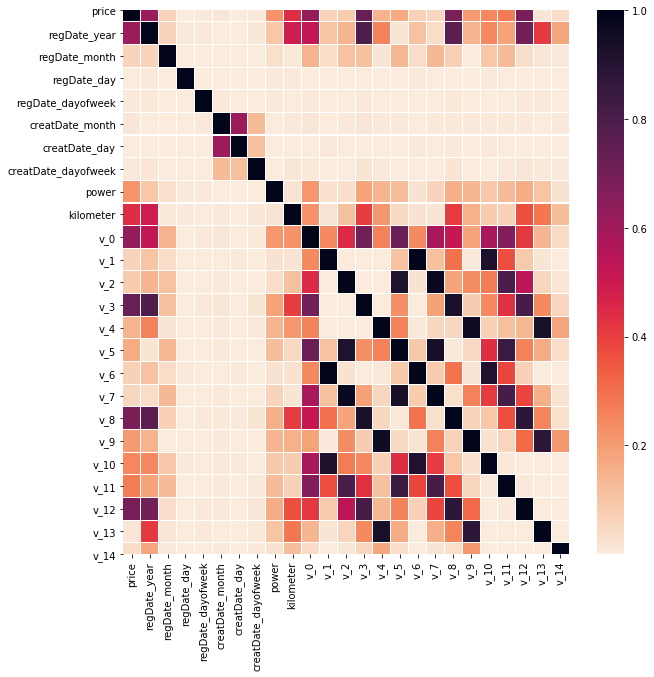

In [18]:
# 读取训练数据集
train_df = pd.read_csv('used_car_train_20200313.csv', sep=' ')
print('train_df.shape: ',train_df.shape)
# train_df.describe()
# plt.figure()
# sns.distplot(train_df['price'])
# plt.figure()
# train_df['price'].plot.box()
# plt.show()

# 读取测试数据集
test_df = pd.read_csv('used_car_testA_20200313.csv', sep=' ')
print('test_df.shape: ',test_df.shape)

# 合并训练+测试数据集
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print('df: ', df.shape)

# 内存仅保留合并后的数据集
del train_df, test_df
gc.collect()
# df.head()

# 数据分为三类：日期、类别、数值
date_cols = ['regDate', 'creatDate']
cate_cols = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode', 'seller', 'offerType']
num_cols = ['power', 'kilometer'] + ['v_{}'.format(i) for i in range(15)]
cols = date_cols + cate_cols + num_cols

# 临时观察各类数据的分布情况，比如缺失值、最大值
# tmp = pd.DataFrame()
# tmp['count'] = df[cols].count().values
# tmp['missing_rate'] = (df.shape[0] - tmp['count']) / df.shape[0]
# tmp['nunique'] = df[cols].nunique().values
# tmp['max_value_counts'] = [df[f].value_counts().values[0] for f in cols]
# tmp['max_value_counts_prop'] = tmp['max_value_counts'] / df.shape[0]
# tmp['max_value_counts_value'] = [df[f].value_counts().index[0] for f in cols]
# tmp.index = cols
# tmp


# 对日期进行细节分析，比如周天对价格的影响
def date_proc(x):
    m = int(x[4:6])
    if m == 0:
        m = 1
    return x[:4] + '-' + str(m) + '-' + x[6:]
# for f in tqdm(date_cols):
for f in date_cols:
    df[f] = pd.to_datetime(df[f].astype('str').apply(date_proc))
    df[f + '_year'] = df[f].dt.year
    df[f + '_month'] = df[f].dt.month
    df[f + '_day'] = df[f].dt.day
    df[f + '_dayofweek'] = df[f].dt.dayofweek
# plt.figure()
# plt.figure(figsize=(16, 6))
# i = 1
# for f in date_cols:
#     for col in ['year', 'month', 'day', 'dayofweek']:
#         plt.subplot(2, 4, i)
#         i += 1
#         v = df[f + '_' + col].value_counts()
#         fig = sns.barplot(x=v.index, y=v.values)
#         for item in fig.get_xticklabels():
#             item.set_rotation(90)
#         plt.title(f + '_' + col)
# plt.tight_layout()
# plt.show()    

# 剔除无意义的参数，比如基本都是同样的值的seller等，增加细节化的日期参数，比如周几
cate_cols.remove('seller')
cate_cols.remove('offerType')
date_cols = ['regDate_year', 'regDate_month', 'regDate_day', 'regDate_dayofweek', 'creatDate_month', 'creatDate_day', 'creatDate_dayofweek']

# 热力图显示各个属性之间的关联度
corr1 = abs(df[~df['price'].isnull()][['price'] + date_cols + num_cols].corr())
plt.figure(figsize=(10, 10))
sns.heatmap(corr1, linewidths=0.1, cmap=sns.cm.rocket_r)

# 对v_N的匿名特征进行分布的可视化分析，发现分布情况相当
# plt.figure()
# plt.figure(figsize=(15, 15))
# i = 1
# for f in num_cols[2:]:
#     plt.subplot(5, 3, i)
#     i += 1
#     sns.distplot(df[~df['price'].isnull()][f], label='train', color='y', hist=False)
#     sns.distplot(df[df['price'].isnull()][f], label='test', color='g', hist=False)
# plt.tight_layout()
# plt.show()

# 查看category对价格的影响
# plt.figure()
# plt.figure(figsize=(20, 18))
# i = 1
# for f in cate_cols + date_cols + num_cols:
#     if df[f].nunique() <= 50:
#         plt.subplot(5, 3, i)
#         i += 1
#         v = df[~df['price'].isnull()].groupby(f)['price'].agg({f + '_price_mean': 'mean'}).reset_index()
#         fig = sns.barplot(x=f, y=f + '_price_mean', data=v)
#         for item in fig.get_xticklabels():
#             item.set_rotation(90)
# plt.tight_layout()
# plt.show()
print('\n')
print('date_cols:',date_cols,'\n ','cate_cols:',cate_cols,'\n','num_cols:',num_cols)
print('df[date_cols+cate_cols+num_cols].shape: ',df[date_cols+cate_cols+num_cols].shape)

In [149]:
'''# 从邮编中提取城市信息，因为是德国的数据，所以参考德国的邮编，相当于加入了先验知识

df['city'] = df['regionCode'].apply(lambda x : str(x)[:-3]).apply(lambda x: x if x != '' else '9').astype('int')'''

0         1
1         4
2         2
3         9
4         6
         ..
199995    3
199996    1
199997    3
199998    1
199999    3
Name: regionCode, Length: 200000, dtype: int32

### 2.特征工程（feat_cols和enc_cols）

In [19]:
# feat_cols 简单的特征工程处理

df['notRepairedDamage'] = df['notRepairedDamage'].astype('str').apply(lambda x: x if x != '-' else None).astype('float16')

feat_cols = []

### count编码
# 举个栗子，数据里有40种品牌，然后这20万行的数据里这个品牌有多少个
# regionCode需要参照Datewhale的教学版本进行特征处理
for f in tqdm([
    'regDate', 'creatDate', 'regDate_year',
    'model', 'brand', 'regionCode'
]):
    df[f + '_count'] = df[f].map(df[f].value_counts())
    feat_cols.append(f + '_count')
    
### 用数值特征对类别特征做统计刻画，随便挑了几个跟price相关性最高的匿名特征
# 比如同样的brand，v_0的最大值是多少……
for f1 in tqdm(['model', 'brand', 'regionCode']):
    g = df.groupby(f1, as_index=False)
    for f2 in tqdm(['v_0', 'v_3', 'v_8', 'v_12']):
        feat = g[f2].agg({
            '{}_{}_max'.format(f1, f2): 'max', '{}_{}_min'.format(f1, f2): 'min',
            '{}_{}_median'.format(f1, f2): 'median', '{}_{}_mean'.format(f1, f2): 'mean',
            '{}_{}_std'.format(f1, f2): 'std', '{}_{}_mad'.format(f1, f2): 'mad'
        })
        df = df.merge(feat, on=f1, how='left')
        feat_list = list(feat)
        feat_list.remove(f1)
        feat_cols.extend(feat_list)
        
### 类别特征的二阶交叉
# 这里是类别特征的关联，比如宝马有A型号，奔驰也有A型号，但它们不是一种车型
for f_pair in tqdm([
    ['model', 'brand'], ['model', 'regionCode'], ['brand', 'regionCode']
]):
    ### 共现次数
    df['_'.join(f_pair) + '_count'] = df.groupby(f_pair)['SaleID'].transform('count')
    ### n unique、熵
    df = df.merge(df.groupby(f_pair[0], as_index=False)[f_pair[1]].agg({
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]): 'nunique',
        '{}_{}_ent'.format(f_pair[0], f_pair[1]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[0], how='left')
    df = df.merge(df.groupby(f_pair[1], as_index=False)[f_pair[0]].agg({
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]): 'nunique',
        '{}_{}_ent'.format(f_pair[1], f_pair[0]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[1], how='left')
    ### 比例偏好
    df['{}_in_{}_prop'.format(f_pair[0], f_pair[1])] = df['_'.join(f_pair) + '_count'] / df[f_pair[1] + '_count']
    df['{}_in_{}_prop'.format(f_pair[1], f_pair[0])] = df['_'.join(f_pair) + '_count'] / df[f_pair[0] + '_count']
    
    feat_cols.extend([
        '_'.join(f_pair) + '_count',
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]), '{}_{}_ent'.format(f_pair[0], f_pair[1]),
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]), '{}_{}_ent'.format(f_pair[1], f_pair[0]),
        '{}_in_{}_prop'.format(f_pair[0], f_pair[1]), '{}_in_{}_prop'.format(f_pair[1], f_pair[0])
    ])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.87s/it]


In [59]:
# enc_cols

train_df = df[~df['price'].isnull()].reset_index(drop=True)
test_df = df[df['price'].isnull()].reset_index(drop=True)


### target encoding目标编码，回归场景相对来说做目标编码的选择更多，不仅可以做均值编码，还可以做标准差编码、中位数编码等
enc_cols = []
stats_default_dict = {
    'max': train_df['price'].max(),
    'min': train_df['price'].min(),
    'median': train_df['price'].median(),
    'mean': train_df['price'].mean(),
    'sum': train_df['price'].sum(),
    'std': train_df['price'].std(),
    'skew': train_df['price'].skew(),
    'kurt': train_df['price'].kurt(),
    'mad': train_df['price'].mad()
}
### 暂且选择这三种编码
enc_stats = ['mean', 'std', 'mad']
skf = KFold(n_splits=5, shuffle=True, random_state=2020)
for f in tqdm(['model', 'brand', 'regionCode']):
    enc_dict = {}
    for stat in enc_stats:
        enc_dict['{}_target_{}'.format(f, stat)] = stat
        train_df['{}_target_{}'.format(f, stat)] = 0
        test_df['{}_target_{}'.format(f, stat)] = 0
        enc_cols.append('{}_target_{}'.format(f, stat))
    for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['price'])):
        trn_x, val_x = train_df.iloc[trn_idx].reset_index(drop=True), train_df.iloc[val_idx].reset_index(drop=True)
        enc_df = trn_x.groupby(f, as_index=False)['price'].agg(enc_dict)
        val_x = val_x[[f]].merge(enc_df, on=f, how='left')
        test_x = test_df[[f]].merge(enc_df, on=f, how='left')
        for stat in enc_stats:
            val_x['{}_target_{}'.format(f, stat)] = val_x['{}_target_{}'.format(f, stat)].fillna(stats_default_dict[stat])
            test_x['{}_target_{}'.format(f, stat)] = test_x['{}_target_{}'.format(f, stat)].fillna(stats_default_dict[stat])
            train_df.loc[val_idx, '{}_target_{}'.format(f, stat)] = val_x['{}_target_{}'.format(f, stat)].values
            test_df['{}_target_{}'.format(f, stat)] += test_x['{}_target_{}'.format(f, stat)].values / skf.n_splits

cols = cate_cols + date_cols + num_cols + feat_cols + enc_cols
sub = test_df[['SaleID']].copy()
test_df = test_df[cols]
labels = train_df['price'].values
train_df = train_df[cols]
print(train_df.shape)
train_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  8.15s/it]

(150000, 140)


,name,model,brand,bodyType,fuelType,gearbox,notRepairedDamage,regionCode,regDate_year,regDate_month,regDate_day,regDate_dayofweek,creatDate_month,creatDate_day,creatDate_dayofweek,power,kilometer,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,regDate_count,creatDate_count,regDate_year_count,model_count,brand_count,regionCode_count,model_v_0_max,model_v_0_min,model_v_0_median,model_v_0_mean,model_v_0_std,model_v_0_mad,model_v_3_max,model_v_3_min,model_v_3_median,model_v_3_mean,model_v_3_std,model_v_3_mad,model_v_8_max,model_v_8_min,model_v_8_median,model_v_8_mean,model_v_8_std,model_v_8_mad,model_v_12_max,model_v_12_min,model_v_12_median,model_v_12_mean,model_v_12_std,model_v_12_mad,brand_v_0_max,brand_v_0_min,brand_v_0_median,brand_v_0_mean,brand_v_0_std,brand_v_0_mad,brand_v_3_max,brand_v_3_min,brand_v_3_median,brand_v_3_mean,brand_v_3_std,brand_v_3_mad,brand_v_8_max,brand_v_8_min,brand_v_8_median,brand_v_8_mean,brand_v_8_std,brand_v_8_mad,brand_v_12_max,brand_v_12_min,brand_v_12_median,brand_v_12_mean,brand_v_12_std,brand_v_12_mad,regionCode_v_0_max,regionCode_v_0_min,regionCode_v_0_median,regionCode_v_0_mean,regionCode_v_0_std,regionCode_v_0_mad,regionCode_v_3_max,regionCode_v_3_min,regionCode_v_3_median,regionCode_v_3_mean,regionCode_v_3_std,regionCode_v_3_mad,regionCode_v_8_max,regionCode_v_8_min,regionCode_v_8_median,regionCode_v_8_mean,regionCode_v_8_std,regionCode_v_8_mad,regionCode_v_12_max,regionCode_v_12_min,regionCode_v_12_median,regionCode_v_12_mean,regionCode_v_12_std,regionCode_v_12_mad,model_brand_count,model_brand_nunique,model_brand_ent,brand_model_nunique,brand_model_ent,model_in_brand_prop,brand_in_model_prop,model_regionCode_count,model_regionCode_nunique,model_regionCode_ent,regionCode_model_nunique,regionCode_model_ent,model_in_regionCode_prop,regionCode_in_model_prop,brand_regionCode_count,brand_regionCode_nunique,brand_regionCode_ent,regionCode_brand_nunique,regionCode_brand_ent,brand_in_regionCode_prop,regionCode_in_brand_prop,model_target_mean,model_target_std,model_target_mad,brand_target_mean,brand_target_std,brand_target_mad,regionCode_target_mean,regionCode_target_std,regionCode_target_mad
0,736,30.0,6,1.0,0.0,0.0,0.0,1046,2004,4,2,4,4,4,0,60,12.5,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,100,7416,11899,3145.0,13719,47,46.342726,28.987024,42.918210,42.750103,2.039852,1.335433,7.375598,-3.651126,1.361821,1.119369,2.000747,1.685237,0.132452,0.000000,0.041461,0.044344,0.028413,0.023923,9.825077,-7.781645,-1.560370,-1.352894,2.292161,1.896074,49.216535,28.987024,43.518332,43.331114,2.282470,1.548165,9.121568,-5.433129,0.953054,0.733410,2.075349,1.700596,0.153849,0.0,0.045827,0.048987,0.029004,0.024024,11.778541,-8.293423,-1.411952,-1.041002,2.414547,1.953658,50.376809,33.511607,45.942332,45.445490,2.369732,1.507840,6.062231,-4.480148,-0.613237,-0.180360,2.049067,1.627380,0.132026,0.000000,0.063441,0.061578,0.029357,0.024186,6.353017,-4.362750,0.558707,0.699833,2.183664,1.773069,3145.0,1.0,0.000000,15,2.161420,0.229244,1.000000,1.0,1938.0,7.390204,27,3.062849,0.021277,0.000318,3,4553,8.091984,14,2.234541,0.063830,0.000219,2774.671714,3039.693856,2298.168884,3613.811755,4698.830289,3197.888310,8415.931034,10276.594200,6996.870392
1,2262,40.0,1,2.0,0.0,0.0,NaN,4366,2003,3,1,5,3,9,2,0,15.0,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,116,6937,12074,5911.0,18326,10,49.517245,33.708559,45.717711,45.594824,1.643656,1.135157,7.849033,-4.628179,-0.051705,0.065820,1.824363,1.539744,0.129159,0.000000,0.056804,0.056247,0.026896,0.022472,10.572566,-5.644524,0.735713,0.650309,2.031854,1.690149,50.735456,31.524342,46.038090,45.836925,2.083827,1.463073,9.201960,-5.411330,-0.611653,-0.448543,1.993718,1.670792,0.153444,0.0,0.064640,0.064518,0.029553,0.024529,12.973057,-6.589651,1.299017,1.201088,2.362357,1.941684

### 3.模型融合

In [ ]:
# lightgbm

oof = np.zeros(train_df.shape[0])
sub['price'] = 0
feat_imp_df = pd.DataFrame({'feat': cols, 'imp': 0})
skf = KFold(n_splits=5, shuffle=True, random_state=2020)
### 参数可以重新设置一下，天池这里面太慢了所以随便跑跑
clf = LGBMRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=2020,
    metric=None
)
for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, labels)):
    print('--------------------- {} fold ---------------------'.format(i))
    t = time.time()
    trn_x, trn_y = train_df.iloc[trn_idx].reset_index(drop=True), labels[trn_idx]
    val_x, val_y = train_df.iloc[val_idx].reset_index(drop=True), labels[val_idx]
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x, val_y)],
        categorical_feature=cate_cols,
        eval_metric='mae',
        early_stopping_rounds=100,
        verbose=200
    )
    feat_imp_df['imp'] += clf.feature_importances_ / skf.n_splits
    oof[val_idx] = clf.predict(val_x)
    sub['price'] += clf.predict(test_df) / skf.n_splits
    print('val mse:', mean_squared_error(val_y, oof[val_idx]))
    print('runtime: {}\n'.format(time.time() - t))

mae = mean_absolute_error(labels, oof)
mse = mean_squared_error(labels, oof)
print('cv mae:', mae)
print('cv mse:', mse)
print('sub mean:', sub['price'].mean())
# sub.to_csv('sub_{}_{}_{}.csv'.format(mae, mse, sub['price'].mean()), index=False)

In [ ]:
## xgb

oof = np.zeros(train_df.shape[0])
sub['price'] = 0
feat_imp_df = pd.DataFrame({'feat': cols, 'imp': 0})
skf = KFold(n_splits=5, shuffle=True, random_state=2020)
### 参数可以重新设置一下，天池这里面太慢了所以随便跑跑
clf = XGBRegressor(
    learning_rate=0.1,
    n_estimators=120,
#     num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=7
#     random_state=2020,
#     metric=None
)
for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, labels)):
    print('--------------------- {} fold ---------------------'.format(i))
    t = time.time()
    trn_x, trn_y = train_df.iloc[trn_idx].reset_index(drop=True), labels[trn_idx]
    val_x, val_y = train_df.iloc[val_idx].reset_index(drop=True), labels[val_idx]
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x, val_y)],
        categorical_feature=cate_cols,
        eval_metric='mae',
        early_stopping_rounds=100,
        verbose=200
    )
    feat_imp_df['imp'] += clf.feature_importances_ / skf.n_splits
    oof[val_idx] = clf.predict(val_x)
    sub['price'] += clf.predict(test_df) / skf.n_splits
    print('val mse:', mean_squared_error(val_y, oof[val_idx]))
    print('runtime: {}\n'.format(time.time() - t))

mae = mean_absolute_error(labels, oof)
mse = mean_squared_error(labels, oof)
print('cv mae:', mae)
print('cv mse:', mse)
print('sub mean:', sub['price'].mean())
sub.to_csv('sub_{}_{}_{}.csv'.format(mae, mse, sub['price'].mean()), index=False)

In [ ]:
# 多种模型的函数设定

def build_model_lr(x_train,y_train):
    reg_model = linear_model.LinearRegression()
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_ridge(x_train,y_train):
    reg_model = linear_model.Ridge(alpha=0.8)#alphas=range(1,100,5)
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_lasso(x_train,y_train):
    reg_model = linear_model.LassoCV()
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_gbdt(x_train,y_train):
    estimator =GradientBoostingRegressor(loss='ls',subsample= 0.85,max_depth= 5,n_estimators = 100)
    param_grid = { 
            'learning_rate': [0.05,0.08,0.1,0.2],
            }
    gbdt = GridSearchCV(estimator, param_grid,cv=3)
    gbdt.fit(x_train,y_train)
    print(gbdt.best_params_)
    # print(gbdt.best_estimator_ )
    return gbdt

def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=5) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=63,n_estimators = 100)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm


In [ ]:
# 划分数据集，并用多种方法训练和预测

## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

## Train and Predict
print('Predict LR...')
model_lr = build_model_lr(x_train,y_train)
val_lr = model_lr.predict(x_val)
subA_lr = model_lr.predict(X_test)

print('Predict Ridge...')
model_ridge = build_model_ridge(x_train,y_train)
val_ridge = model_ridge.predict(x_val)
subA_ridge = model_ridge.predict(X_test)

print('Predict Lasso...')
model_lasso = build_model_lasso(x_train,y_train)
val_lasso = model_lasso.predict(x_val)
subA_lasso = model_lasso.predict(X_test)

print('Predict GBDT...')
model_gbdt = build_model_gbdt(x_train,y_train)
val_gbdt = model_gbdt.predict(x_val)
subA_gbdt = model_gbdt.predict(X_test)


### XGB和lgb模型

In [ ]:
print('predict XGB...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
subA_xgb = model_xgb.predict(X_test)

print('predict lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
subA_lgb = model_lgb.predict(X_test)

##### 1）加权融合

In [ ]:
def Weighted_method(test_pre1,test_pre2,test_pre3,w=[1/3,1/3,1/3]):
    Weighted_result = w[0]*pd.Series(test_pre1)+w[1]*pd.Series(test_pre2)+w[2]*pd.Series(test_pre3)
    return Weighted_result

## Init the Weight
w = [0.3,0.4,0.3]

## 测试验证集准确度
val_pre = Weighted_method(val_lgb,val_xgb,val_gbdt,w)
MAE_Weighted = mean_absolute_error(y_val,val_pre)
print('MAE of Weighted of val:',MAE_Weighted)

## 预测数据部分
subA = Weighted_method(subA_lgb,subA_xgb,subA_gbdt,w)
print('Sta inf:')
Sta_inf(subA)
## 生成提交文件
sub = pd.DataFrame()
sub['SaleID'] = X_test.index
sub['price'] = subA
sub.to_csv('./sub_Weighted.csv',index=False)

##### 2）stacking融合

In [ ]:
## Stacking

## 第一层
train_lgb_pred = model_lgb.predict(x_train)
train_xgb_pred = model_xgb.predict(x_train)
train_gbdt_pred = model_gbdt.predict(x_train)

Strak_X_train = pd.DataFrame()
Strak_X_train['Method_1'] = train_lgb_pred
Strak_X_train['Method_2'] = train_xgb_pred
Strak_X_train['Method_3'] = train_gbdt_pred

Strak_X_val = pd.DataFrame()
Strak_X_val['Method_1'] = val_lgb
Strak_X_val['Method_2'] = val_xgb
Strak_X_val['Method_3'] = val_gbdt

Strak_X_test = pd.DataFrame()
Strak_X_test['Method_1'] = subA_lgb
Strak_X_test['Method_2'] = subA_xgb
Strak_X_test['Method_3'] = subA_gbdt

In [ ]:
## level2-method 
model_lr_Stacking = build_model_lr(Strak_X_train,y_train)
## 训练集
train_pre_Stacking = model_lr_Stacking.predict(Strak_X_train)
print('MAE of Stacking-LR:',mean_absolute_error(y_train,train_pre_Stacking))

## 验证集
val_pre_Stacking = model_lr_Stacking.predict(Strak_X_val)
print('MAE of Stacking-LR:',mean_absolute_error(y_val,val_pre_Stacking))

## 预测集
print('Predict Stacking-LR...')
subA_Stacking = model_lr_Stacking.predict(Strak_X_test)


In [ ]:
subA_Stacking[subA_Stacking<10]=10  ## 去除过小的预测值

sub = pd.DataFrame()
sub['SaleID'] = X_test.index
sub['price'] = subA_Stacking
sub.to_csv('./sub_Stacking.csv',index=False)